In [55]:
import funclib as flib
from scipy.stats.stats import pearsonr
import string

In [5]:
directory = "../../scripts/alphas"

Read original data

In [6]:
taxa = ["Mammals.Homo_sapiens", "Birds.Gallus_gallus", "Snakes.Thamnophis_elegans"]

og_data = pd.DataFrame()
for taxon in taxa:
    df = pd.read_csv("{}/{}.LM.tsv".format(directory, taxon),sep="\t")
    df["Taxon"] = taxon.split(".")[0]
    og_data = pd.concat([og_data, df])
    
og_data["source"] = "original"

palette = pd.read_csv("../../data/plot_colors.tsv",sep="\t").set_index("Order")["Color"].to_dict()

Taxa and other sources, in the same order

In [22]:
sources = {"LM":"Mammals.Mus_musculus", 
           "mean":"Mammals.Homo_sapiens,Birds.Gallus_gallus,Snakes.Thamnophis_elegans", 
           "LM.CpGOut":"Mammals.Homo_sapiens,Birds.Gallus_gallus,Snakes.Thamnophis_elegans", 
           "with_reptime.LM":"Mammals.Homo_sapiens", 
           "LM.microchroms-included":"Birds.Gallus_gallus,Snakes.Thamnophis_elegans"}
names = {"LM":"reference_seq",
         "mean":"without_regression",
         "LM.CpGOut":"CpG_masked",
         "with_reptime.LM":"RT_included",
         "LM.microchroms-included":"micro_included"
        }

Pair original alphas with conditions

In [32]:
# Mutation type
mut_type = "mod"

# Read data
comparisons_df = pd.DataFrame()

for source,taxa in sources.items():

    data = pd.DataFrame()
    for taxon in taxa.split(","):
        df = pd.read_csv("{}/{}.{}.tsv".format(directory, taxon, source),sep="\t")
        if source=="mean":
            df = df[df.weighted_mean==True]
        group = taxon.split(".")[0]
        df["Taxon"] = group
        data = pd.concat([data, df])

    # Pair with original dataset
    og_data_2pair = og_data[(og_data.mut_type==mut_type) & (og_data.Taxon.isin(data.Taxon.unique()))].set_index("species")[["alpha","alpha_lwr","alpha_upr"]]
    data = data[(data.mut_type==mut_type)].set_index("species")[["alpha","alpha_lwr","alpha_upr","Taxon"]]
    paired_data = og_data_2pair.join(data, lsuffix=".original").reset_index()
    paired_data["condition"] = names[source]
    
    # Add to df
    comparisons_df = pd.concat([comparisons_df, paired_data])

# gBGC
paired_data = og_data[og_data.mut_type=="gc-BGC-unaffected"].set_index("species")[["alpha","alpha_lwr","alpha_upr"]].join(og_data[og_data.mut_type=="mod"].set_index("species")[["alpha","alpha_lwr","alpha_upr"]], rsuffix=".original").reset_index()
paired_data["condition"] = "gBGC_unaffected"
paired_data["Taxon"] = og_data[og_data.mut_type=="mod"].Taxon.values
comparisons_df = pd.concat([comparisons_df, paired_data])

DNM data, to include if needed

In [34]:
selected_species = ["Mus_musculus"]
dnms = pd.read_csv("{}/dnm_est_mutrate.tsv".format(directory.replace("scripts/alphas","data")),sep="\t")
dnms["Species"] = ["_".join(sp.split()[:2]) for sp in dnms.Species]

subd_dnms = dnms[dnms.Species.isin(selected_species)]
dnm_alpha = {}
for sp,df in subd_dnms.groupby("Species"):
    p = df["Pat DNMs"].sum()
    m = df["Mat DNMs"].sum()
    dnm_alpha[sp] = p/m

Generate plot

In [62]:
condition_labels = {"reference_seq": "Different reference sequence",
                    "CpG_masked": "Excluding CpG sites",
                    "RT_included": "Including replication timing",
                    "without_regression": "Mean substitution rate", 
                    "micro_included": "Including microchromosomes",
                    "gBGC_unaffected":"Sites unaffected by gBGC"}
condition_order = ['reference_seq', 'CpG_masked', 'RT_included', 'without_regression', 'micro_included', 'gBGC_unaffected']

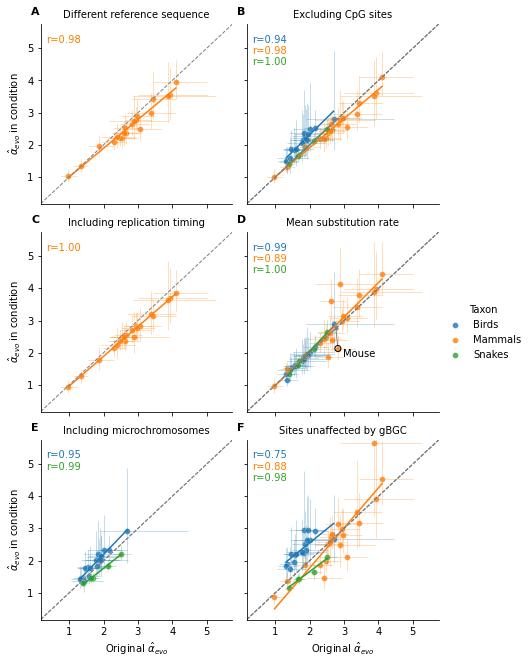

In [67]:
axes_limit = [0.17, 5.75]

g = sns.FacetGrid(data=comparisons_df, col="condition", col_wrap=2, col_order=condition_order,
                  hue="Taxon", hue_order=["Birds", "Mammals", "Snakes"], legend_out=True)

g.map(sns.scatterplot, "alpha.original", "alpha", alpha=0.8)
g.map(sns.regplot, "alpha.original", "alpha", scatter=False, line_kws={"linewidth":1.5}, label="", ci=None)
g.map(flib.identity_line, color="gray", linewidth=1, label="")

g.set_axis_labels(r"Original $\hat{\alpha}_{evo}$", r"$\hat{\alpha}_{evo}$ in condition")
g.add_legend()

for iletter,(condition, ax) in enumerate(g.axes_dict.items()):
    
    cond_df = comparisons_df[comparisons_df.condition==condition]
    
    # CIs
    ax.hlines(y=cond_df.alpha, xmin=cond_df["alpha_lwr.original"], xmax=cond_df["alpha_upr.original"], 
              linewidth=0.5, zorder=1, color=[palette[t] for t in cond_df.Taxon], alpha=0.5)
    ax.vlines(x=cond_df["alpha.original"], ymin=cond_df["alpha_lwr"], ymax=cond_df["alpha_upr"], 
              linewidth=0.5, zorder=1, color=[palette[t] for t in cond_df.Taxon], alpha=0.5)
    
    # Annotate stats per taxon
    for i,(taxon,subd) in enumerate(cond_df.groupby("Taxon")):
        r, pval = pearsonr(subd["alpha"], subd["alpha.original"])
        x_text = axes_limit[0]*2
        y_text = axes_limit[-1]*0.9-(0.35*i)
        ax.annotate("r={:.2f}".format(r), xy=(x_text, y_text), 
                    transform=ax.transAxes, color=palette[taxon])
        ax.set_title(condition_labels[condition], fontsize=10)
    
    # Mouse DNMs
    if condition=="without_regression":
        xa_dict = cond_df.set_index("species")[["alpha", "alpha.original"]].to_dict()
        for sp in selected_species:
            x = xa_dict["alpha.original"][sp]
            y = xa_dict["alpha"][sp]
            dnm_a = dnm_alpha[sp]
            ax.scatter(x, y, color="none", edgecolor="black",zorder=10)
            ax.scatter(dnm_a, dnm_a, color="gray", s=10, zorder=25)
            ax.plot([x, dnm_a],[y,dnm_a],
                    zorder=0, linewidth=1, color="gray")
            ax.annotate("Mouse", xy=(x*1.05,y), ha="left", va="top", fontsize=10)
            
    # Letter panel
    ax.text(-0.05, 1.05, string.ascii_uppercase[iletter], transform=ax.transAxes, 
            size=11, weight="bold")
            
    # Limits for axes
    ax.set_xlim(axes_limit)
    ax.set_ylim(axes_limit)
    # Legend
    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles[-3:], labels[-3:], title="Taxon", loc=4)
        
#plt.tight_layout()
#plt.show()
plt.savefig("../pdfs/Figure_SX_conditions_alpha_CIs.pdf", bbox_inches = 'tight')